In [29]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [59]:
#Load data
ipage_df = pd.read_csv('/content/drive/MyDrive/OMDENA_PROJECTS/2410_iPAGE_SoilData_cleaned.csv')
isda_df = pd.read_csv('/content/drive/MyDrive/OMDENA_PROJECTS/isda_final.csv')

In [60]:
isda_df.columns

Index(['longitude', 'latitude', 'Boron', 'SOC', 'Nitrogen', 'pH', 'Phosphorus',
       'Potassium', 'Sulfur', 'Zinc', 'Sand', 'Silt', 'Clay', 'Area',
       'Soil group', 'Land class', 'Soil type'],
      dtype='object')

In [61]:
#Rename ipage_df & iSDA columns
ipage_df.rename( columns = { 'Area' : 'area',
                            'Land class': 'land_class',
                            'soil group' : 'soil_group',
                            'knit (surface)':'soil_type',
                            'SOC (%)': 'SOC',
                            'Nitrogen N (%)': 'nitrogen',
                            'Potassium K (meq/100)': 'potassium',
                            'Phosphorus P (ug/g)': 'phosphorus',
                            'Sulfur S (ug/g)': 'sulfur',
                            'Boron B (ug/g)': 'boron',
                            'Zinc Zn (ug/g)': 'zinc'}, inplace = True)
isda_df.rename(columns= { 'Soil group': 'soil_group',
                           'Land class': 'land_class',
                           'Soil type': 'soil_type',
                           'Boron': 'boron',
                           'Nitrogen': 'nitrogen',
                           'Phosphorus':'phosphorus',
                           'Potassium':'potassium',
                           'Sulfur':'sulfur',
                           'Sand':'sand',
                           'Silt':'silt',
                           'Clay':'clay',
                           'Zinc':'zinc',
                           'Area':'area'}, inplace = True)


In [62]:
#Drop year of collection
ipage_df.drop(columns = ['Data Collection Year'], inplace = True)

In [63]:
ipage_df['soil_type'].unique()

array(['Clay loam ', 'loam', 'brick', 'in the sand', nan, 'loam clay'],
      dtype=object)

In [64]:
#split soil type in ipage data to sand ,silt and clay
# Fill nulls for unknown Soil type to conserve data
ipage_df['soil_type'] = ipage_df['soil_type'].fillna('unknown')

# Create map for Soil type
soil_mapping = {
    'loam': {'sand': 40.0,'silt': 40.0,'clay': 20.0},
    'Clay loam ': {'sand': 33.0,'silt': 33.0,'clay': 33.0},
    'loam clay': {'sand': 33.0,'silt': 33.0,'clay': 33.0},
    'brick': {'sand': 20.0,'silt': 20.0,'clay': 60.0},
    'in the sand': {'sand': 80.0,'silt': 10.0,'clay': 10.0},
    'unknown': {'sand': 33.0,'silt': 33.0,'clay': 33.0}
}

# Create columns to split Soil type in to % Sand, Silt and Clay
ipage_df['sand'] = ipage_df['soil_type'].map(lambda x: soil_mapping[x]['sand'])
ipage_df['silt'] = ipage_df['soil_type'].map(lambda x: soil_mapping[x]['silt'])
ipage_df['clay'] = ipage_df['soil_type'].map(lambda x: soil_mapping[x]['clay'])

# Drop nulls and unnecessary Soil type
ipage_df.dropna(inplace=True)
ipage_df.drop(columns='soil_type', inplace=True)

In [37]:
ipage_df.sample(5)

,area,soil_group,land_class,pH,SOC,nitrogen,potassium,phosphorus,sulfur,boron,zinc,sand,silt,clay
74,Mithpukur,Pirgacha,high ground,5.3,1.32,0.0700,0.30,122.30,17.20,0.54,0.83,40.0,40.0,20.0
394,Gangachara,Gangachara,Medium high land,5.6,1.50,0.0019,0.35,23.00,17.00,0.40,1.00,33.0,33.0,33.0
539,Taraganj Thana,Pirgacha,high ground,5.1,1.20,0.0600,0.30,117.00,32.00,0.29,0.40,33.0,33.0,33.0
442,Kaunia upazila,Berries,high ground,5.3,1.92,0.1000,0.15,19.42,12.59,0.16,3.60,40.0,40.0,20.0
511,Kaunia upazila,Alluvial soil of Teesta,Medium high land,5.4,2.68,0.1300,0.31,6.08,10.17,0.62,0.60,40.0,40.0,20.0


In [66]:
#Convert isda_df SOC and Nitrogen from mg/kg to % to match ipage data
isda_df['SOC'] /= 10
isda_df['nitrogen'] /= 10

In [67]:
#Potassium unit conversion from meq/100 to mg/kg. Potassium (K) 1 meq/100g = 390 mg/kg.
isda_df['potassium'] /= 390

In [68]:
#Create a source column
ipage_df['source'] = 'ipage'
isda_df['source'] = 'isda'
# Combine the two datasets for plotting
df = pd.concat([ipage_df, isda_df], ignore_index=True)
df.shape

(2727, 18)

In [76]:
df.columns

Index(['area', 'soil_group', 'land_class', 'pH', 'SOC', 'nitrogen',
       'potassium', 'phosphorus', 'sulfur', 'boron', 'zinc', 'sand', 'silt',
       'clay'],
      dtype='object')

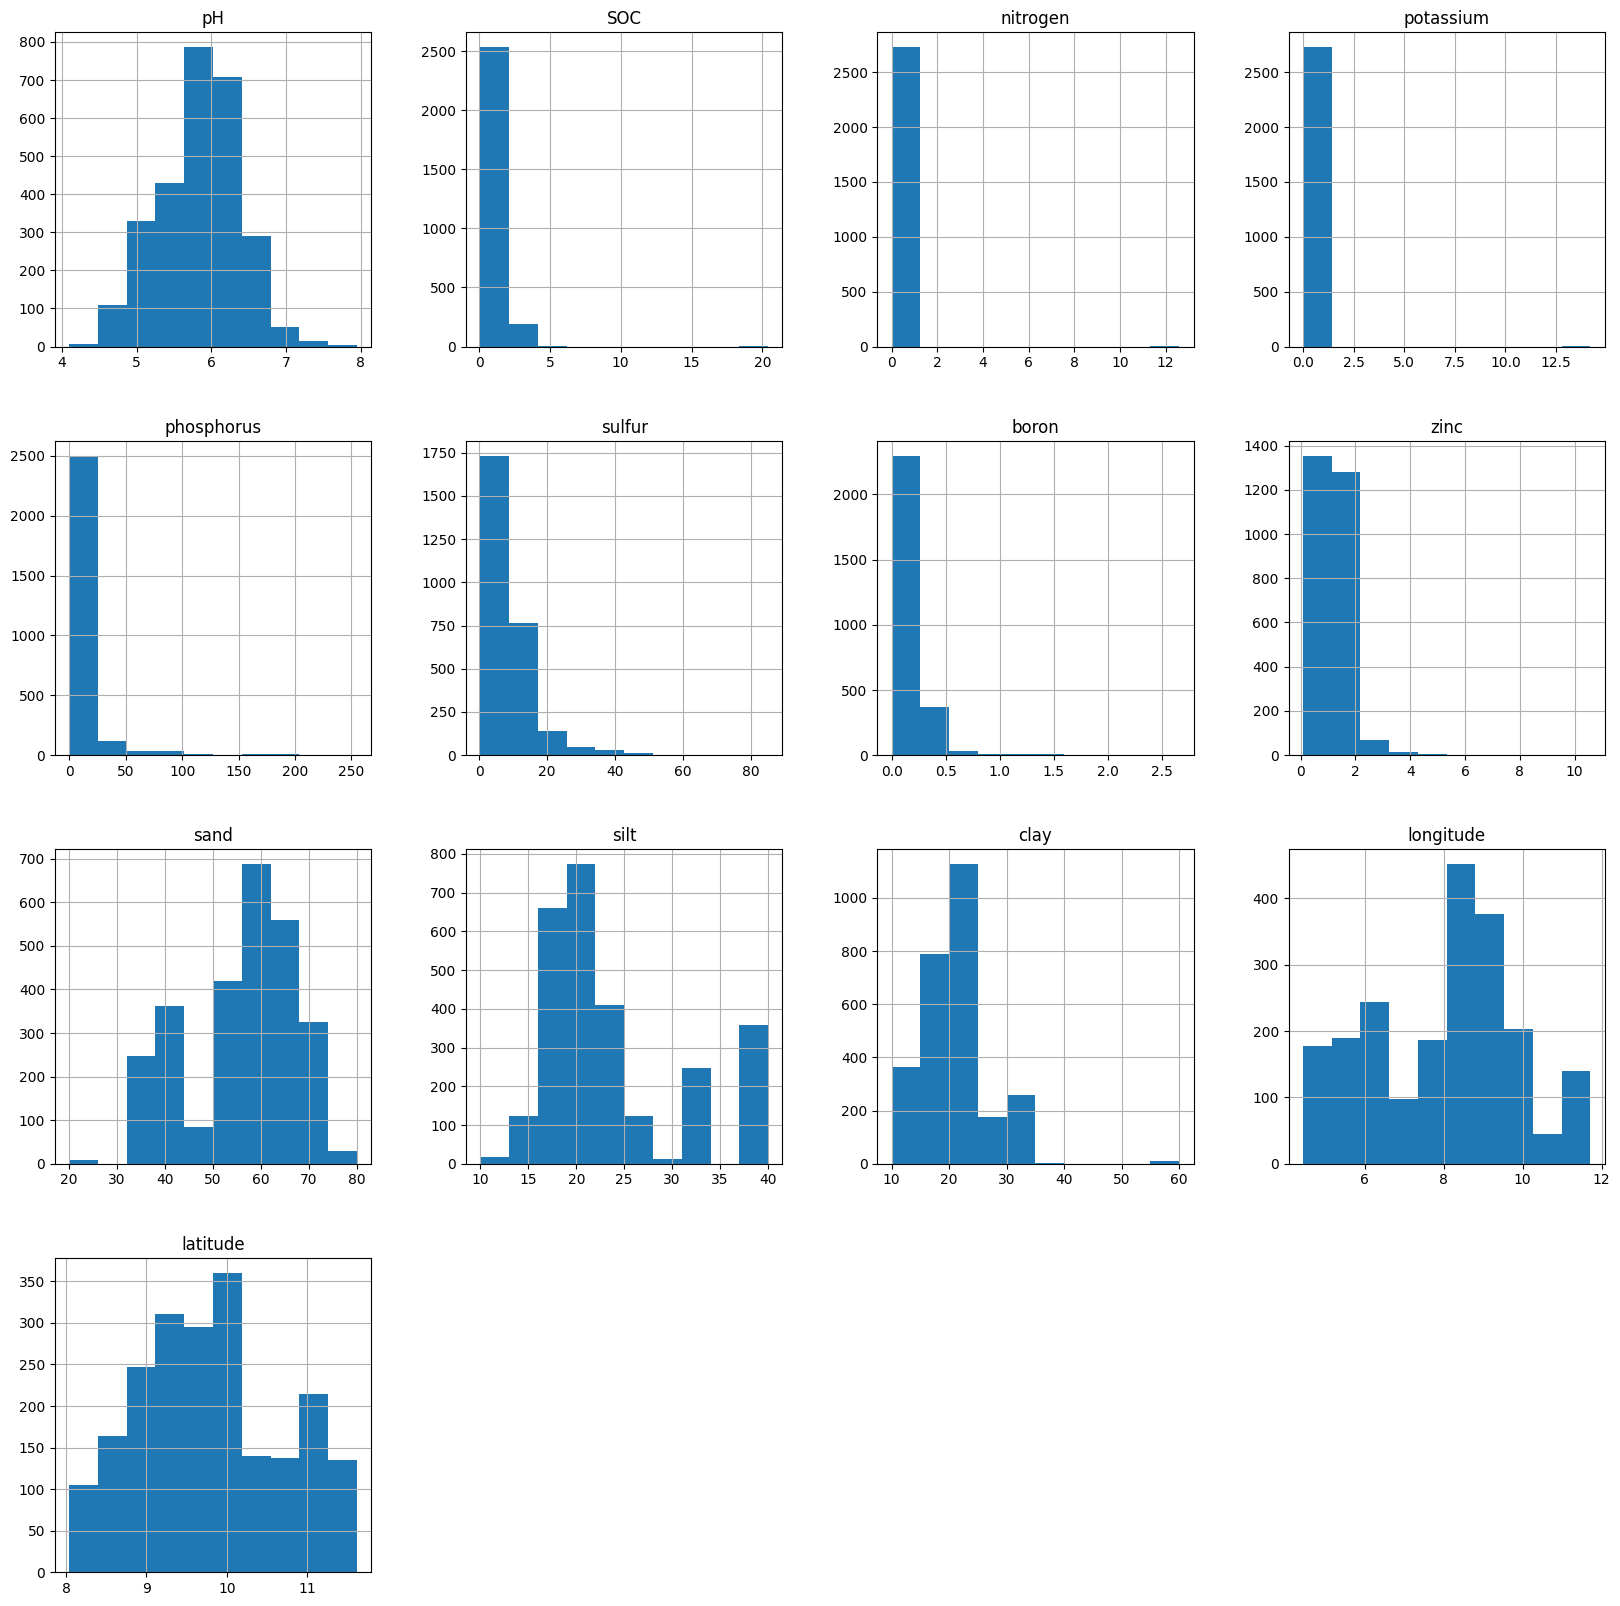

In [41]:
#Plot histogram to view distribution of merged dataset
df.hist(figsize=(20,20))
plt.show()

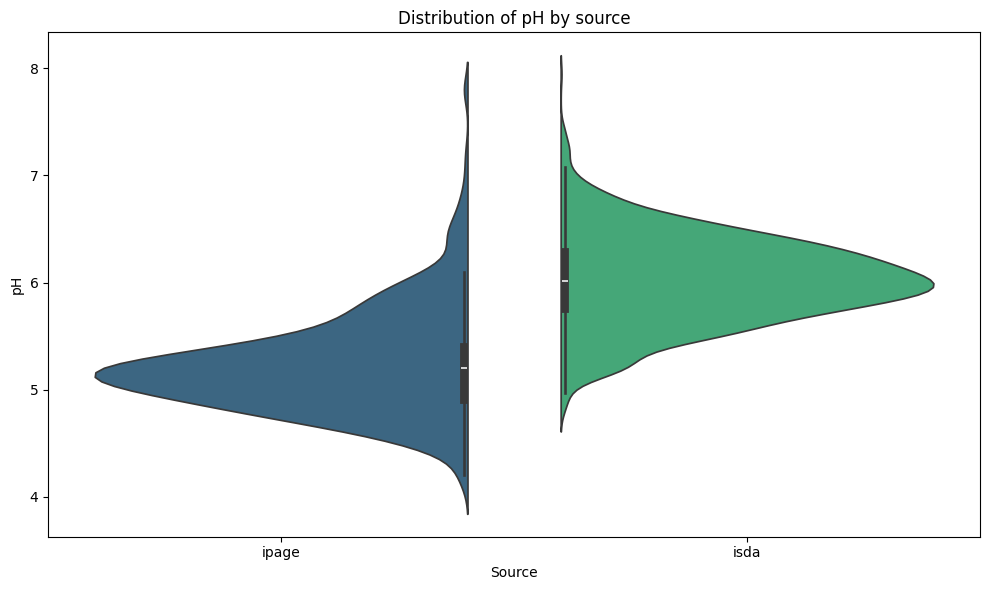

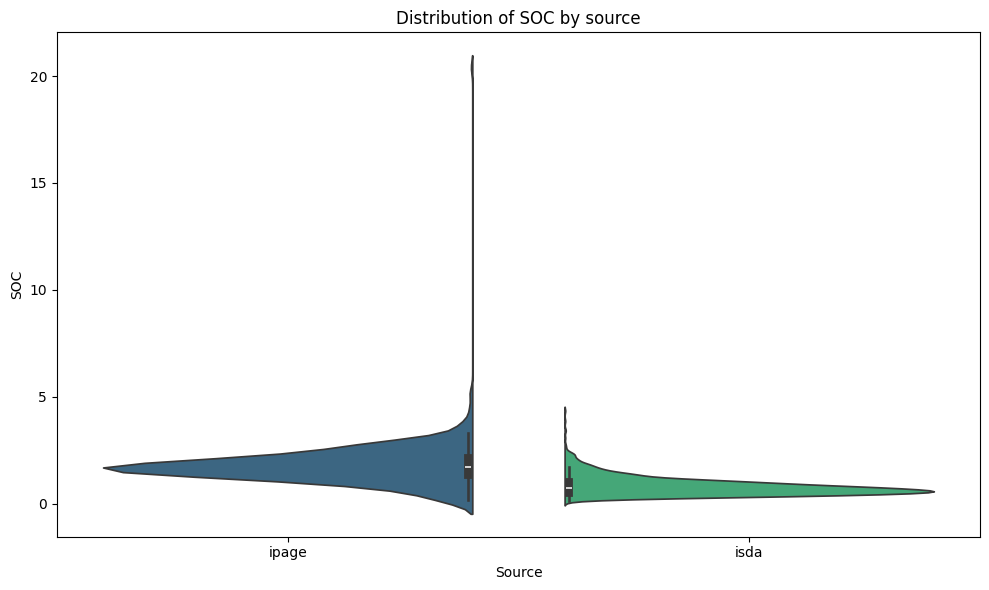

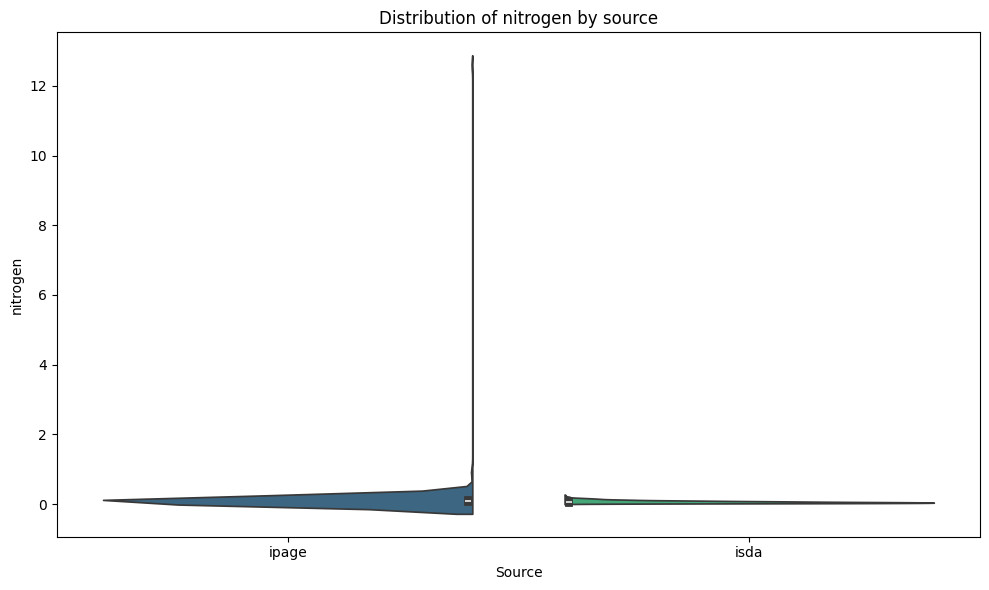

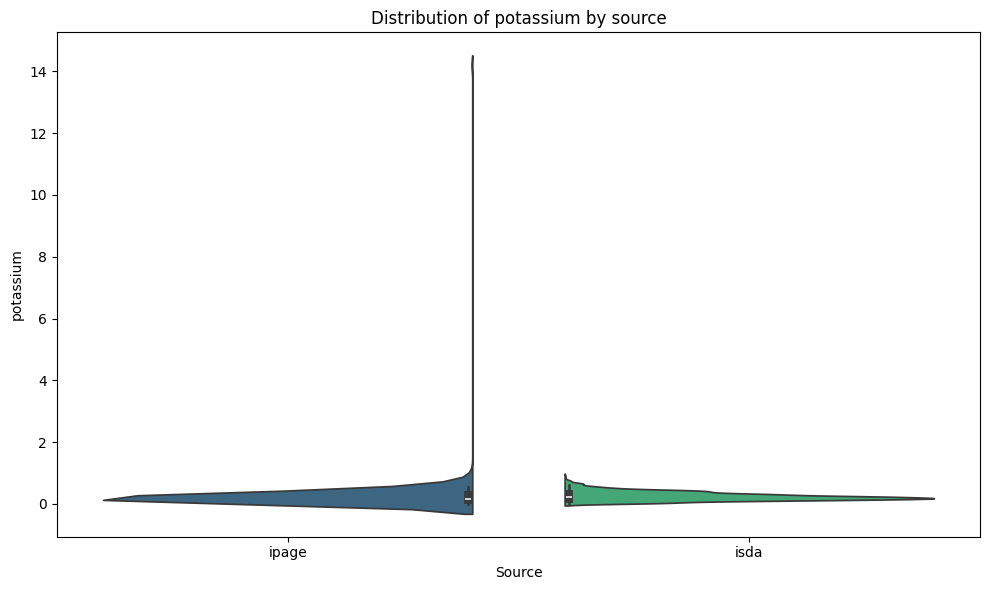

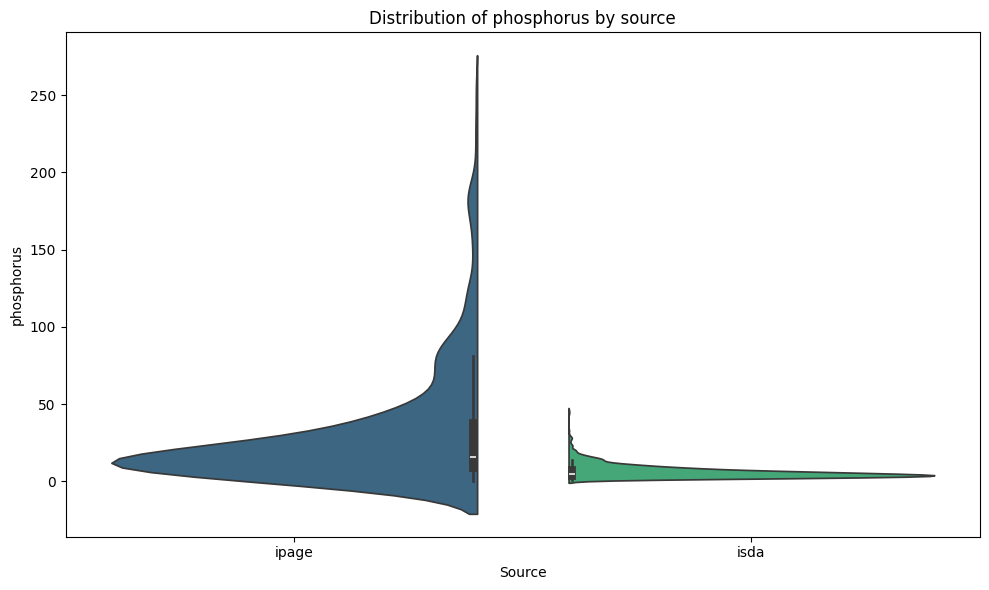

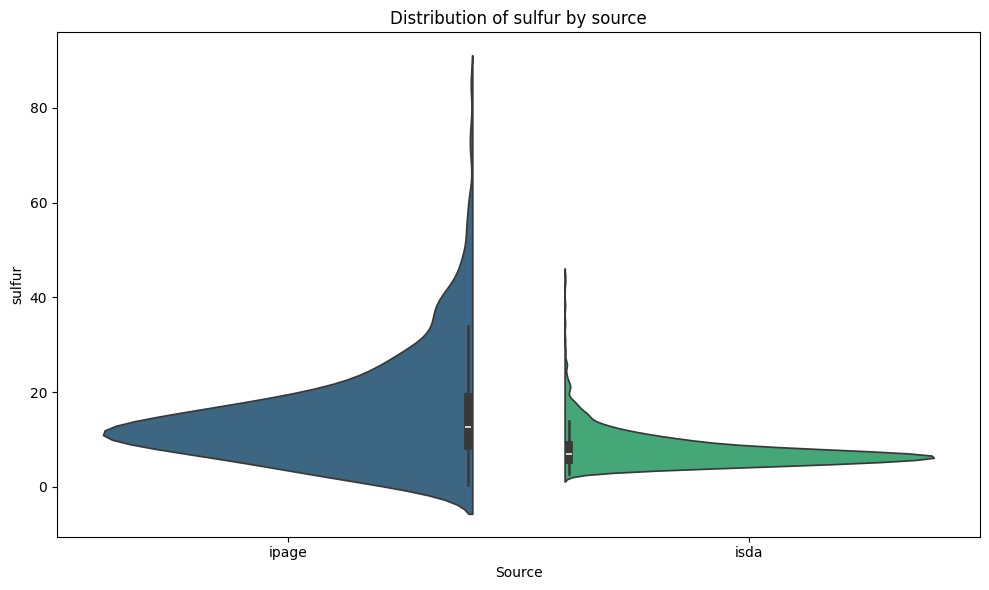

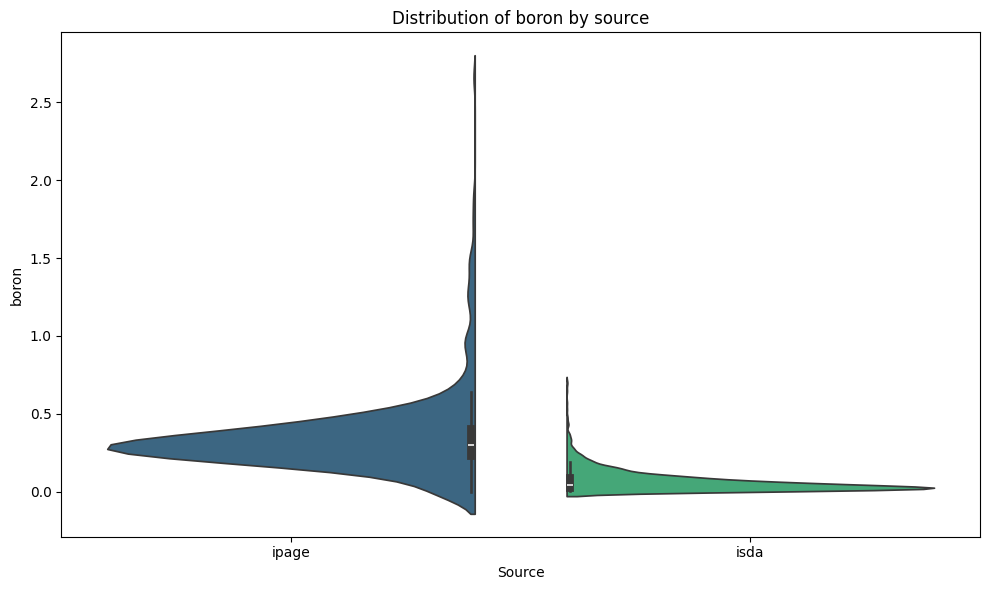

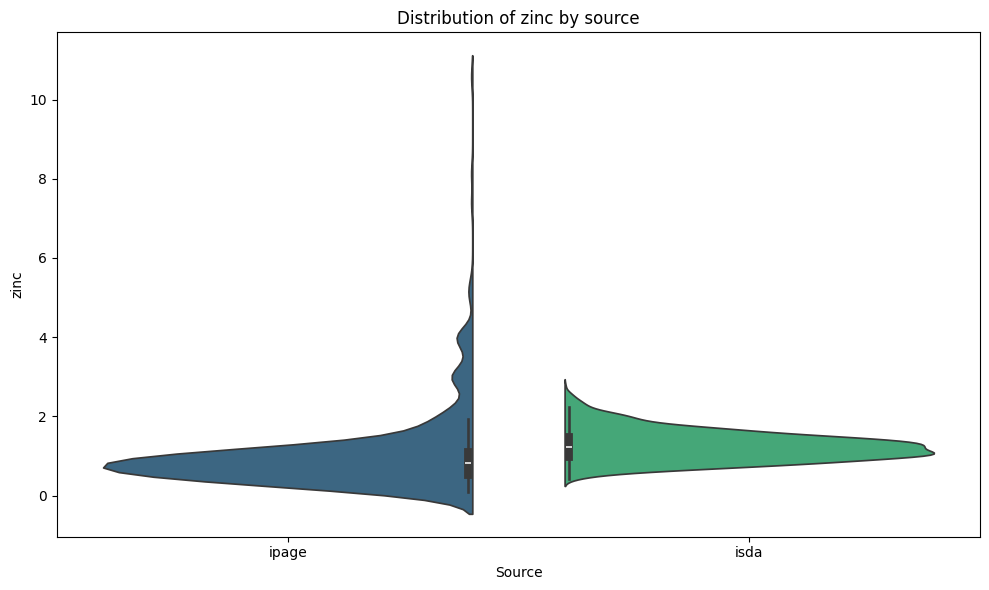

In [42]:
#plot violin plots to visualise dstribution of different cols in both datasets
#select numerical cols
target_cols = ['pH','SOC', 'nitrogen', 'potassium', 'phosphorus', 'sulfur', 'boron', 'zinc']

for col in target_cols:
  plt.figure(figsize=(10,6))
  sns.violinplot(data=df,
               x='source',
               y=col,
              legend=False,
              split=True,
              hue='source',
              palette='viridis')
  plt.title(f'Distribution of {col} by source')
  plt.xlabel('Source')
  plt.ylabel(col)
  plt.tight_layout()
  plt.show()
  #Ensure you have source column on your dataset

In [75]:
df.drop(columns=['source','longitude','latitude','soil_type'], inplace=True)

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2727 entries, 0 to 2726
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   area        2727 non-null   object 
 1   soil_group  2727 non-null   object 
 2   land_class  2727 non-null   object 
 3   pH          2727 non-null   float64
 4   SOC         2727 non-null   float64
 5   nitrogen    2727 non-null   float64
 6   potassium   2727 non-null   float64
 7   phosphorus  2727 non-null   float64
 8   sulfur      2727 non-null   float64
 9   boron       2727 non-null   float64
 10  zinc        2727 non-null   float64
 11  sand        2727 non-null   float64
 12  silt        2727 non-null   float64
 13  clay        2727 non-null   float64
dtypes: float64(11), object(3)
memory usage: 298.4+ KB


In [78]:
#Remove extreme outliers
clean_df = df[
    (df['boron'] < 1.0) &
    (df['zinc'] < 5.0) &
    (df['SOC'] < 5.0) &
    (df['sulfur'] < 40.0) &
    (df['nitrogen'] < 0.3) &
    (df['potassium'] < 5.0) &
    (df['phosphorus'] < 75.0)]

In [79]:
clean_df.shape

(2615, 14)

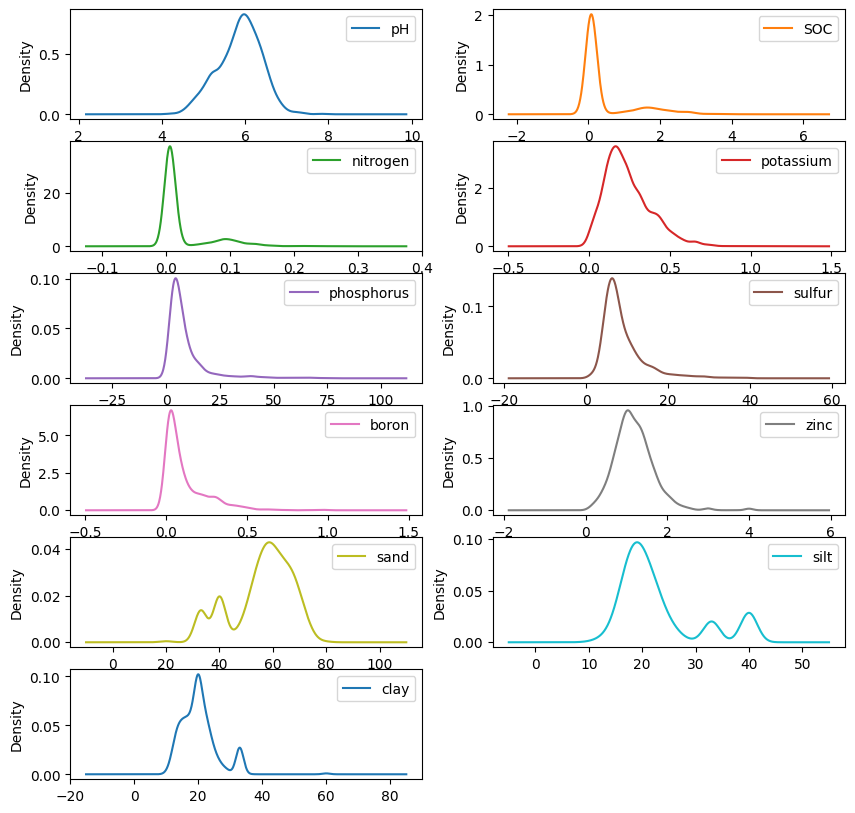

In [80]:
# Lets check the distribution of numerical columns without outliers
import math
features = ['pH', 'SOC', 'nitrogen', 'potassium', 'phosphorus',
                     'sulfur', 'boron', 'zinc', 'sand', 'silt', 'clay']
# Determine the number of columns (features) and set the layout accordingly
n_plots = len(features)
n_rows = math.ceil(n_plots / 2)
layout = (n_rows, 2)

clean_df[features].plot(kind='density', subplots=True, layout=layout, sharex=False, figsize=(10, 10));

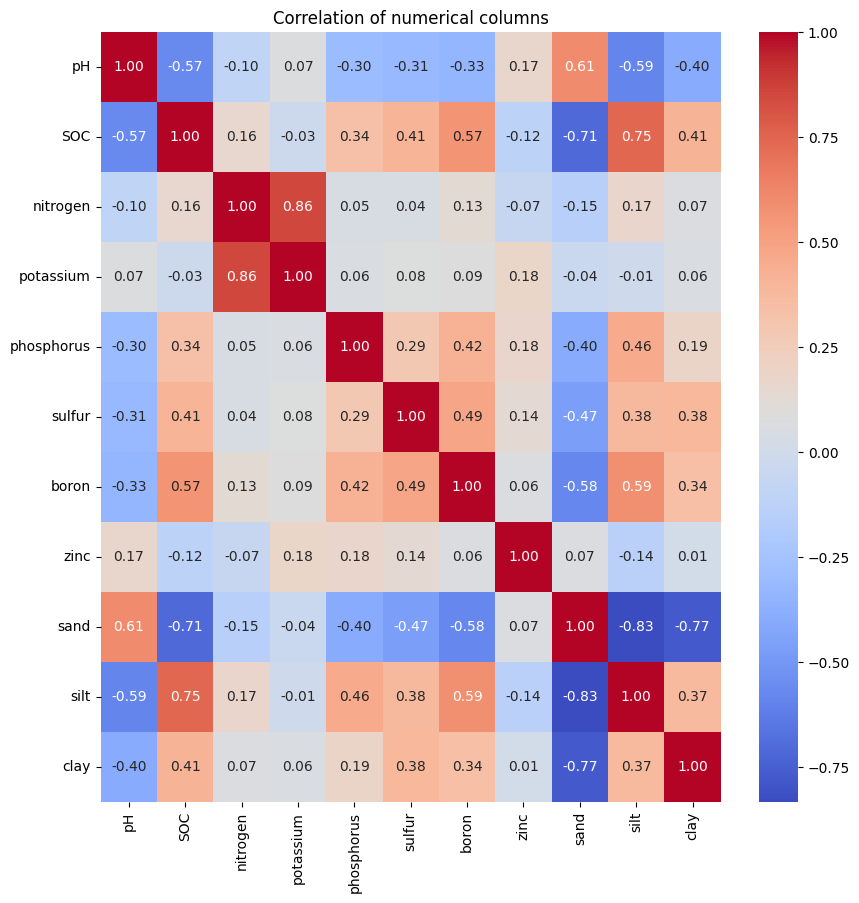

In [82]:
#plot correlation
numerical_cols = ['pH', 'SOC', 'nitrogen', 'potassium', 'phosphorus',
                     'sulfur', 'boron', 'zinc', 'sand', 'silt', 'clay']
# Subset the DataFrame with numerical columns
df_numerical = df[numerical_cols]

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(df_numerical.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of numerical columns")
plt.show()

# Predict Soil Organic Carbon (SOC)
**Data Preprocessing**

In [83]:
clean_df.columns

Index(['area', 'soil_group', 'land_class', 'pH', 'SOC', 'nitrogen',
       'potassium', 'phosphorus', 'sulfur', 'boron', 'zinc', 'sand', 'silt',
       'clay'],
      dtype='object')

In [84]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Define categorical columns
categorical_cols = ['area', 'soil_group', 'land_class']

# Initialize the OneHotEncoder with a custom feature name separator
ohe = OneHotEncoder(sparse_output=False)

# Apply one-hot encoding to the categorical columns
one_hot_encoded = ohe.fit_transform(clean_df[categorical_cols])

# Get the encoded feature names with underscore separator
encoded_feature_names = ohe.get_feature_names_out(categorical_cols)

# Create a DataFrame for the one-hot encoded data
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoded_feature_names, index=clean_df.index)

# Concatenate the one-hot encoded dataframe with the original dataframe
df_encoded = pd.concat([clean_df, one_hot_df], axis=1)

# Drop the original categorical columns
df = df_encoded.drop(categorical_cols, axis=1)

# Display the result
#print(f"Encoded DataFrame:\n{df.head(5)}")


In [86]:
df.shape

(2615, 50)

In [87]:
#Fit multilinear regression model
X = df.drop(columns=['SOC'])
y = df['SOC']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
# making predictions
predictions = model.predict(X_test)
# model evaluation
print('R2 score : ', r2_score(y_test, predictions))
print(
'mean_squared_error : ', mean_squared_error(y_test, predictions))
print(
'mean_absolute_error : ', mean_absolute_error(y_test, predictions))


R2 score :  0.920321428271416
mean_squared_error :  0.04802771906371022
mean_absolute_error :  0.08504938149875108


In [88]:
#Fit a random forest regressor
# Create a pipeline with StandardScaler and Random forest regressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(n_estimators=50, max_depth=7, random_state=42))
])

# Train the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

# Evaluate the model
print("SOC R²:", r2_score(y_test, y_pred_test))
print("SOC MAE:", mean_absolute_error(y_test, y_pred_test))

SOC R²: 0.9382422287448144
SOC MAE: 0.07364880023271278


In [ ]:
#Support vector regressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
#Create a pipeline with StandardScaler and Support vector regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', SVR(kernel='linear'))
])

# Train the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

# Evaluate the model
print("Zinc R²:", r2_score(y_test, y_pred_test))
print("Zinc MAE:", mean_absolute_error(y_test, y_pred_test))

In [89]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error

# Create pipelines with the specified hyperparameters
pipelines = {
    'scale': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='linear', C=0.1, epsilon=0.001, gamma='scale'))
    ]),
    'auto': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='linear', C=0.1, epsilon=0.001, gamma='auto'))
    ])
}

# Train and evaluate each pipeline
for gamma_value, pipeline in pipelines.items():
    print(f"Evaluating pipeline with gamma='{gamma_value}'")

    # Train the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    # Evaluate the model
    print(f"Gamma: {gamma_value}")
    print("SOC R²:", r2_score(y_test, y_pred_test))
    print("SOC MAE:", mean_absolute_error(y_test, y_pred_test))
    print("-" * 30)


Evaluating pipeline with gamma='scale'
Gamma: scale
SOC R²: 0.914570444886139
SOC MAE: 0.07943358989432062
------------------------------
Evaluating pipeline with gamma='auto'
Gamma: auto
SOC R²: 0.914570444886139
SOC MAE: 0.07943358989432062
------------------------------


#PREDICT BORON

In [90]:
X = df.drop(columns=['boron','SOC','zinc'])
y = df['boron']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [92]:
# Create a pipeline with StandardScaler and LinearRegression
from sklearn.linear_model import Ridge
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])

# Train the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

# Evaluate the model
print("Boron R²:", r2_score(y_test, y_pred_test))
print("Boron MAE:", mean_absolute_error(y_test, y_pred_test))

Boron R²: 0.7373695935430493
Boron MAE: 0.0448856915473709


In [93]:
#random forest regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(n_estimators=50, max_depth=7, random_state=42))
])

# Train the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

# Evaluate the model
print("Boron R²:", r2_score(y_test, y_pred_test))
print("Boron MAE:", mean_absolute_error(y_test, y_pred_test))


Boron R²: 0.7502607502780434
Boron MAE: 0.04230606243375381


In [94]:
#Create a pipeline with StandardScaler and Support vector regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', SVR(kernel='linear'))
])

# Train the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

# Evaluate the model
print("Boron R²:", r2_score(y_test, y_pred_test))
print("Boron MAE:", mean_absolute_error(y_test, y_pred_test))

Boron R²: 0.6105445493202466
Boron MAE: 0.06753044761793031


In [96]:
# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)

# Fit the regressor with x and y data
regressor.fit(X_train, y_train)


RandomForestRegressor(n_estimators=10, oob_score=True, random_state=0)

In [98]:
# Evaluating the model
from sklearn.metrics import mean_squared_error, r2_score

# Access the OOB Score
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

# Making predictions on the same data or new data
predictions = regressor.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y_test, predictions)
print(f'R-squared: {r2}')

Out-of-Bag Score: 0.4843795212926214
Mean Squared Error: 0.0053893193275183805
R-squared: 0.6962713547244176


In [ ]:
# Initialize dictionary to store results
results = {}

# Define metrics evaluation function
def evaluate_model(y_test, y_pred, model_name):
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Print performance metrics
    print(f"{model_name} Performance:")
    print(f"R² Score: {r2}")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print("-" * 40)

    # Store results
    results[model_name] = {'MSE': mse, 'MAE': mae, 'R² Score': r2}

# Define models to use
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(max_depth=20, random_state=42),
    "XGBoost": XGBRegressor(objective='reg:squarederror'),
    #"Support Vector Regression": SVR(C=10, epsilon=0.01, kernel='linear')
}

# Define function to evaluate dataset
def evaluate_dataset(models, df, evaluate_model):
    # Extract features and target from the DataFrame
    features = df.drop(columns=['Boron', 'Zinc', 'SOC'])  # Drop target columns
    target = df[['Boron', 'Zinc', 'SOC']]  # Target columns as DataFrame

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    print(f"Evaluating models on the dataset:")

    # Loop through models
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Evaluate the model
        evaluate_model(y_test, y_pred, model_name)

        # Calculate permutation importance
        perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
        importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Permutation Importance': perm_importance.importances_mean
        }).sort_values(by='Permutation Importance', ascending=False)

        # Print feature importance
        print(f"Permutation Importance for {model_name}:")
        print(importance_df)
        print("-" * 30)


In [ ]:
evaluate_dataset(models, df, evaluate_model)